# **Загрузка** **Датасета**

In [ ]:
pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download arkhoshghalb/twitter-sentiment-analysis-hatred-speech

Dataset URL: https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech
License(s): unknown
twitter-sentiment-analysis-hatred-speech.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip twitter-sentiment-analysis-hatred-speech

Archive:  twitter-sentiment-analysis-hatred-speech.zip
  inflating: test.csv                
  inflating: train.csv               


# **Необходимые для работы библиотеки**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from textblob import TextBlob
from textblob import Word
nltk.download('wordnet')

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

from sklearn import model_selection, preprocessing, linear_model, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from imblearn.under_sampling import NearMiss
from sklearn.naive_bayes import MultinomialNB
from sklearn import model_selection, preprocessing, linear_model, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# **Изучение начальных данных Датасета**

Читаем наш Датасет состоящий из двух частей: Train и Test.

Видим что размер Train: 31962 строк и  3 столбца. Размер Test: 17197 строк и 2 столбца.

Прочитаем по первые 5 строк каждого набора - видим что присутствуют вредные артефакты - лишняя пунктуация, стоп-слова и т.д. - делаем вывод что будет необходима обработка текста перед тем как загнать его в модели.

Так же видим что в наборе Train присутствуют два столбца формата int64 и один столбец формата object - наш главный столбец tweet с которым в дальнейшем будем работать - переводить в вектора с помощью TF-IDF.
В наборе Test форматы столбца аналогичные, но отсутствует столбец label - выборка тестовая.

При выводе на экран 5 первых строк набора попробовал новую для себя возможность визуализировать цвет числовых столбцов - style.background_gradient.

In [ ]:
df_train = pd.read_csv('train.csv', sep = ',')
df_test = pd.read_csv('test.csv', sep = ',')

In [ ]:
df_train.head(n = 5).style.background_gradient(cmap = "gist_gray")

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation


In [ ]:
df_test.head(n = 5).style.background_gradient(cmap = "gist_gray")

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedication #willpower to find #newmaterialsâ¦
1,31964,@user #white #supremacists want everyone to see the new â #birdsâ #movie â and hereâs why
2,31965,safe ways to heal your #acne!! #altwaystoheal #healthy #healing!!
3,31966,"is the hp and the cursed child book up for reservations already? if yes, where? if no, when? ððð #harrypotter #pottermore #favorite"
4,31967,"3rd #bihday to my amazing, hilarious #nephew eli ahmir! uncle dave loves you and missesâ¦"


In [ ]:
print("Размер набора Train: {} Размер набора Test: {}".format(df_train.shape, df_test.shape))

Размер набора Train: (31962, 3) Размер набора Test: (17197, 2)


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17197 entries, 0 to 17196
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      17197 non-null  int64 
 1   tweet   17197 non-null  object
dtypes: int64(1), object(1)
memory usage: 268.8+ KB


# **Обработка** **датасета**

Так как при первичном изучении Датасета было обнаружено в нем некоторое количество вредных артефактов которые могут повлиять на качество работы моделей, необходимо очистить текстовую часть выборки. Для этого будем использовать некоторые функции:

- lower_case: перевод в нижний регистр
- punctuation_removal: удаление знаков пунктуации
- stop_words_removal: удаление стпо-слов - которые подргружаем из библиотеки
- frequent_words_removal: удаление часто-используемых слов которые могут повлиять на качество работы моделей
- rare_words_removal: удаление редких слов которые могут повилиять на качество работы моделей
- spell_correction: проверка правописания текста (подгружаем библиотеку)
- lemmatization: преобразование слова в его базовую форму

Прогоняем функции для обоих наборов - Train и Test.

После очистки выводим еще раз первые 5 строк и видим изменения после очитски текста.

К сожалению не смог удалить символ # из некторых твитов - пробовал разные функции - почему то ничего не вышло. В свободное время еще уделю время этой проблеме. Но пока будем работать с тем что получилось.

# Очистка набора Train

In [ ]:
def lower_case(df):
    df['tweet'] = df['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [ ]:
def punctuation_removal(df):
    df['tweet'] = df['tweet'].str.replace('[^\w\s]','')

In [ ]:
stop = stopwords.words('english')
def stop_words_removal(df):
    df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [ ]:
freq = pd.Series(' '.join(df_train['tweet']).split()).value_counts()[:10]
freq

@user    17291
the      10065
to        9768
a         6261
i         5655
you       4949
and       4831
in        4570
for       4435
of        4152
Name: count, dtype: int64

In [ ]:
def frequent_words_removal(df):
    df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

In [ ]:
rare = pd.Series(' '.join(df_train['tweet']).split()).value_counts()[-10:]
rare

nouveau               1
cops"                 1
smth,                 1
opinion?              1
#capitalist;          1
architecture.         1
#socialist;           1
#environmentalist;    1
#coalitionist;        1
chisolm.              1
Name: count, dtype: int64

In [ ]:
def rare_words_removal(df):
    df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

In [ ]:
def spell_correction(df):
    return df['tweet'][:5].apply(lambda x: str(TextBlob(x).correct()))

In [ ]:
def lemmatization(df):
    df['tweet'] = df['tweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
    print(df['tweet'].head())

In [ ]:
lower_case(df_train)
punctuation_removal(df_train)
stop_words_removal(df_train)
frequent_words_removal(df_train)
rare_words_removal(df_train)
spell_correction(df_train)
lemmatization(df_train)

0    father dysfunctional selfish drag kid dysfunct...
1    thanks #lyft credit can't use cause offer whee...
2                                       bihday majesty
3    #model love u take u time urð±!!! ððð...
4                      factsguide: society #motivation
Name: tweet, dtype: object


In [ ]:
df_train.head(n = 5).style.background_gradient(cmap = "gist_gray")

,id,label,tweet
0,1,0,father dysfunctional selfish drag kid dysfunction. #run
1,2,0,thanks #lyft credit can't use cause offer wheelchair van pdx. #disapointed #getthanked
2,3,0,bihday majesty
3,4,0,#model love u take u time urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society #motivation


# Очистка набота Test

In [ ]:
freq = pd.Series(' '.join(df_test['tweet']).split()).value_counts()[:10]
freq

@user    9409
the      5424
to       5186
a        3281
i        3129
and      2662
you      2607
for      2473
in       2346
of       2241
Name: count, dtype: int64

In [ ]:
rare = pd.Series(' '.join(df_test['tweet']).split()).value_counts()[-10:]
rare

agent,          1
lawyer,         1
sweatshi        1
rolf's          1
zeal            1
modes           1
#kingdomcome    1
mary's          1
#citationâ¦    1
#shoegaze       1
Name: count, dtype: int64

In [ ]:
lower_case(df_test)
punctuation_removal(df_test)
stop_words_removal(df_test)
frequent_words_removal(df_test)
rare_words_removal(df_test)
spell_correction(df_test)
lemmatization(df_test)

0    #studiolife #aislife #requires #passion #dedic...
1    #white #supremacists want everyone see new â...
2    safe way heal #acne!! #altwaystoheal #healthy ...
3    hp cursed child book reservation already? yes,...
4    3rd #bihday amazing, hilarious #nephew eli ahm...
Name: tweet, dtype: object


In [ ]:
df_test.head(n = 5).style.background_gradient(cmap = "gist_gray")

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedication #willpower find #newmaterialsâ¦
1,31964,#white #supremacists want everyone see new â #birdsâ #movie â hereâs
2,31965,safe way heal #acne!! #altwaystoheal #healthy #healing!!
3,31966,"hp cursed child book reservation already? yes, where? no, when? ððð #harrypotter #pottermore #favorite"
4,31967,"3rd #bihday amazing, hilarious #nephew eli ahmir! uncle dave love missesâ¦"


# **Визуализация**

Визуализируем наши выборки.

На Kaggle нашел интересный вариант который визуально мне понравился - подгружаешь картинку и на нее можно вывести самые часто используемые слова.

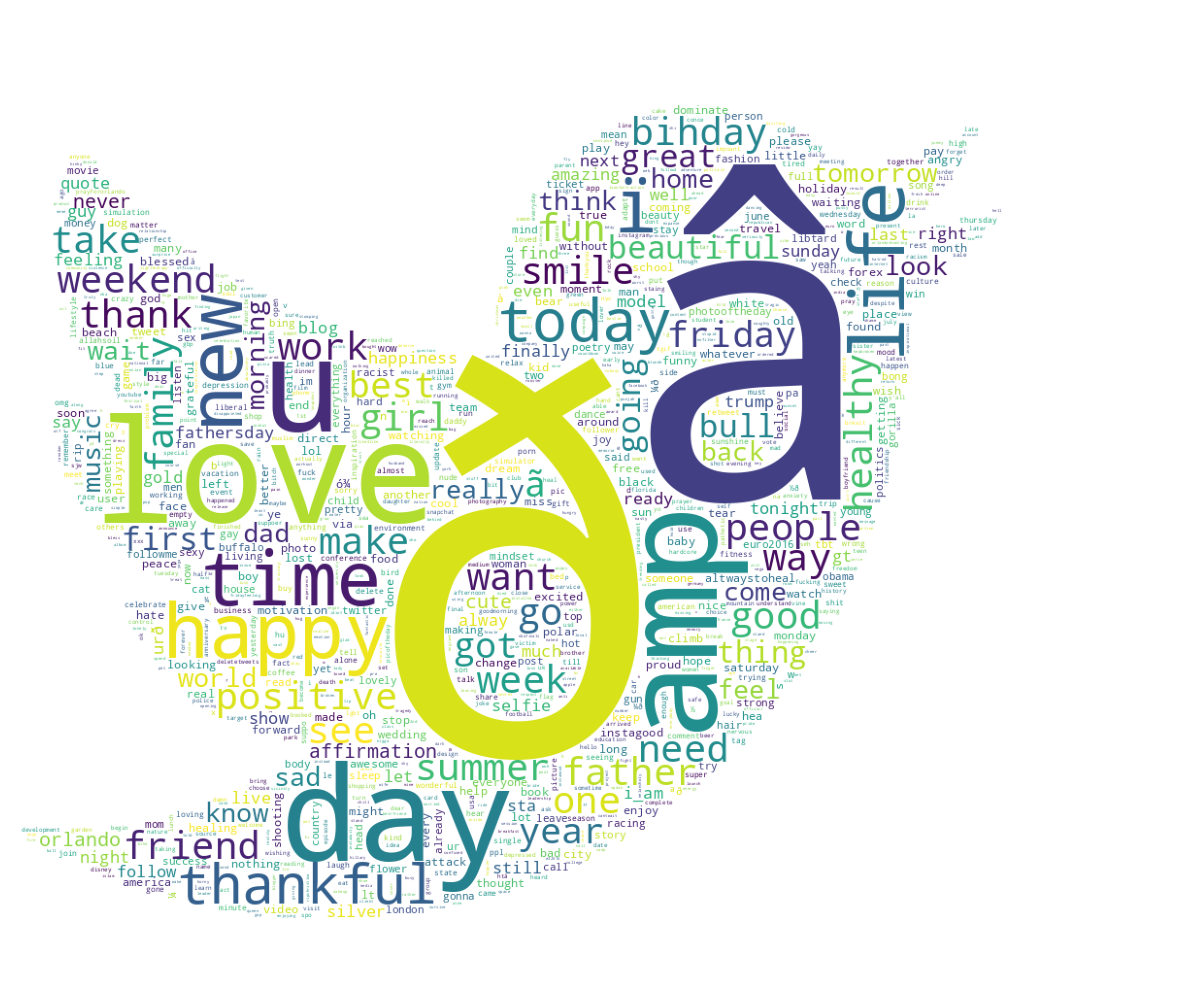

In [ ]:
tw_mask = np.array(Image.open('twitter_mask3.jpg'))

text = " ".join(i for i in df_train.tweet)

wc = WordCloud(background_color = "white",
               width = 600, mask = tw_mask,
               height = 600,
               contour_width = 0,
               contour_color = "red",
               max_words = 1000,
               scale = 1,
               collocations = False,
               repeat = True,
               min_font_size = 1)

wc.generate(text)

plt.figure(figsize = [15, 15])
plt.imshow(wc)
plt.axis("off")
plt.show;

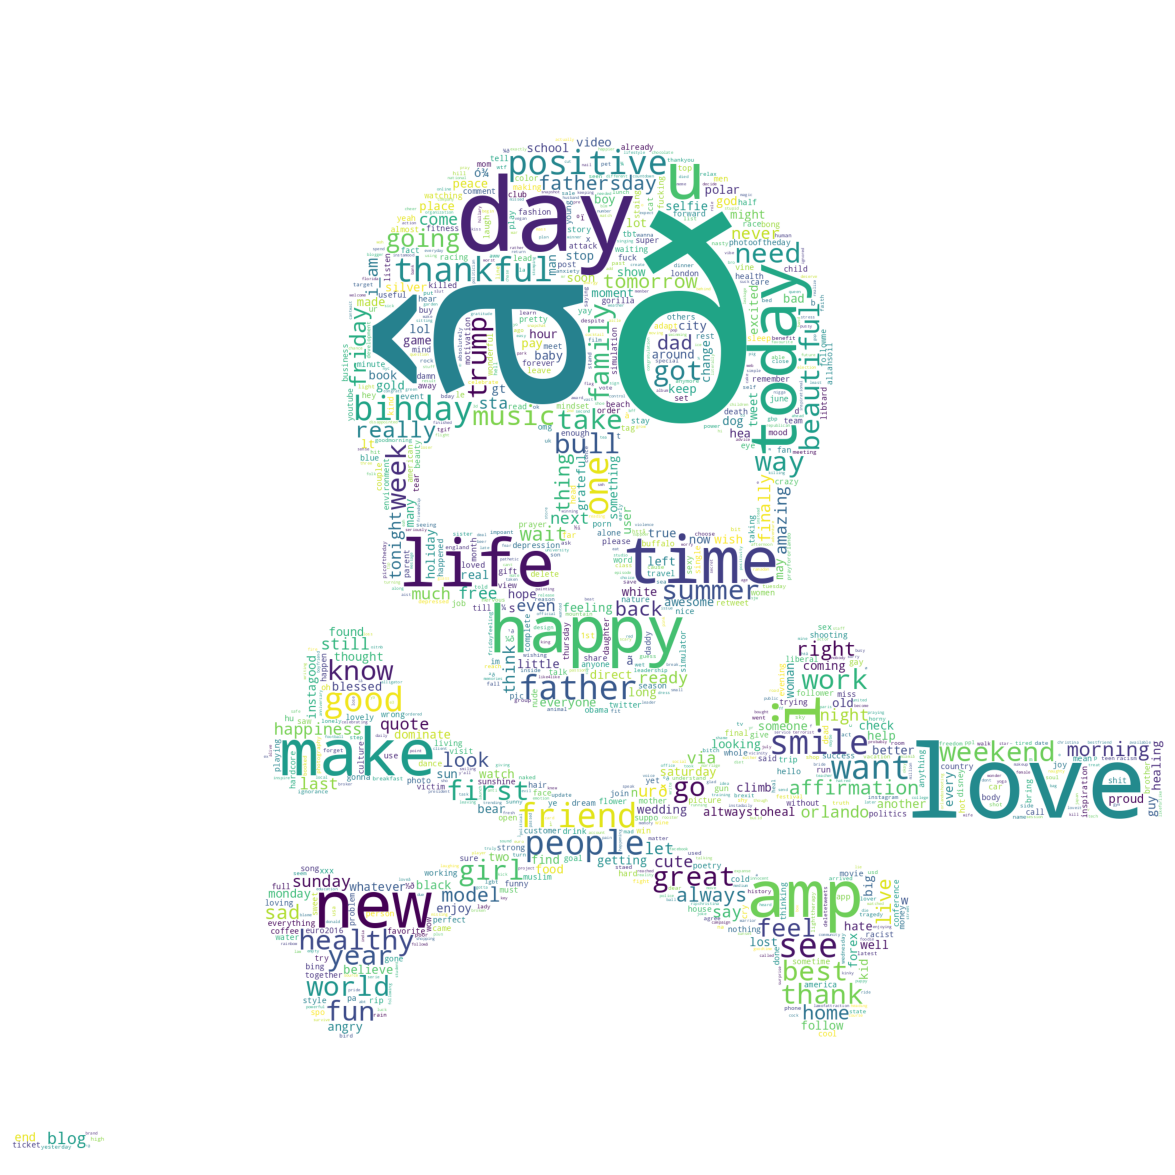

In [ ]:
tw_mask = np.array(Image.open('skull.jpg'))

text = " ".join(i for i in df_test.tweet)

wc = WordCloud(background_color = "white",
               width = 600, mask = tw_mask,
               height = 600,
               contour_width = 0,
               contour_color = "red",
               max_words = 1000,
               scale = 1,
               collocations = False,
               repeat = True,
               min_font_size = 1)

wc.generate(text)

plt.figure(figsize = [15, 15])
plt.imshow(wc)
plt.axis("off")
plt.show;

# **Баланс классов, Разбивка и Векторизация данных TF-IDF**

Проверим баланс классов: видим что классы не равны количественно, но попробуем прогнать модели без выравнивания классов - может полученные результаты окажутся достаточными и при несбалансированных классах.

Разобьем нашу обучающую выборку.

Проведем векторизацию данных с помощью метода TF-IDF.

In [ ]:
df_train.groupby("label").count().style.background_gradient(cmap = "gist_gray_r")

,id,tweet
label,,
0,29720,29720
1,2242,2242


In [ ]:
x = df_train["tweet"]
y = df_train["label"]

train_x, test_x, train_y, test_y = model_selection.train_test_split(x, y, test_size = 0.20, shuffle = True, random_state = 11)

In [ ]:
tf_idf_word_vectorizer = TfidfVectorizer()
tf_idf_word_vectorizer.fit(train_x)

x_train_tf_idf_word = tf_idf_word_vectorizer.transform(train_x)
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)

x_train_tf_idf_word.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# **Построение моделей**

Будем использовать три модели:

- Logistic regression + TF-IDF
- Naive Bayes + TF-IDF
- XGBoost + TF-IBF

Замерим скорость выполнения каждоый модели и в конце сравним точность и скорость выполнения.

# Logistic regression + TF-IDF

In [ ]:
%%time
log = linear_model.LogisticRegression()
log_model = log.fit(x_train_tf_idf_word, train_y)
accuracy = model_selection.cross_val_score(log_model,
                                           x_test_tf_idf_word,
                                           test_y,
                                           cv = 20).mean()
print("Точность модели: ", accuracy)

Точность модели:  0.9314904976489029
CPU times: user 10.9 s, sys: 9.56 s, total: 20.4 s
Wall time: 24.9 s


# Naive Bayes + TF-IDF

In [ ]:
%%time
from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
NB_classifier.fit(x_train_tf_idf_word, train_y)
NB_pred = NB_classifier.predict(x_test_tf_idf_word)

ac_NB = accuracy_score(test_y, NB_pred)
print('Точность модели: ', ac_NB)

Точность модели:  0.9360237760050055
CPU times: user 20.8 ms, sys: 0 ns, total: 20.8 ms
Wall time: 31.4 ms


# XGBoost + TF-IBF

In [ ]:
%%time
xgb = XGBClassifier()
xgb_model = xgb.fit(x_train_tf_idf_word,train_y)
accuracy = model_selection.cross_val_score(xgb_model,
                                           x_test_tf_idf_word,
                                           test_y,
                                           cv = 20).mean()
print("Точность модели: ", accuracy)

Точность модели:  0.9425950235109717
CPU times: user 2min 42s, sys: 508 ms, total: 2min 42s
Wall time: 1min 40s


# Выводы

Точность всех трех модлей примерно на одном уровне - 93-94%.
Но скорость выполнения у всех отличается существенно:

- Logistic regression + TF-IDF: время выполнения примерно 25 секунд с точностью 93%
- Naive Bayes + TF-IDF: скорость выполнения 0.3 секунды с точностью 93 процента
- XGBoost + TF-IBF: скорость выполнения 100 секунд с точностью 94%.

Можно слелать вывод что реализовывать предсказание настроений на основе твитов лучше всего с помощью модели Naive Bayes + TF-IDF - данная модель выдает высокую точность при самый низкой скорости выполнения.  

# **Обучение BERT**

Предварительная обработка данных:
- Разделение тренировочного набора на тренировочную и валидационную части
- Загрузка предобученного токенизатора BERT
- Токенизация данных
- Преобразование меток

In [ ]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_train['tweet'], df_train['label'], test_size=0.1, random_state=42)

Токенизация

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True)
test_encodings = tokenizer(list(df_test['tweet']), truncation=True, padding=True)

train_labels = list(train_labels)
val_labels = list(val_labels)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Создание и обучение модели:
- Установка устройства
- Создание собственного класса для Датасета
- Создание Датасетов - train, val, test
- Загрузка модели и перенос на GPU
- Настйрока оптимизатора Adam
- Настройка DataLoader

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertForSequenceClassification, AdamW

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TwitterDataset(Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]).to(device) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx]).to(device)
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

train_dataset = TwitterDataset(train_encodings, train_labels)
val_dataset = TwitterDataset(val_encodings, val_labels)
test_dataset = TwitterDataset(test_encodings)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased').to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Обучение модели:
- Установим количсество эпох = 3 (по итогу каждая эпоха обучалась в районе 11 мин)
- Визуализируем процесс обучения чтобы понимать сколько времени займет процесс обучения
- Собственно обучим модель

In [ ]:
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm

epochs = 3

total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

    for batch in progress_bar:
        optimizer.zero_grad()
        inputs = {key: val.to(device) for key, val in batch.items()}
        outputs = model(**inputs)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=epoch_loss / len(progress_bar))

    print(f"Epoch {epoch+1} average loss: {epoch_loss / len(train_loader)}")

model.save_pretrained('path/to/save/model')

Epoch 1 average loss: 0.13495441757723195


Epoch 2 average loss: 0.060528691491390264


Epoch 3 average loss: 0.02146087412491456


Оценка модели:
- Достигнутая точность получилась равной 0.97 что считаю хорошим результатом

In [ ]:
from sklearn.metrics import accuracy_score

model.eval()
preds = []
labels = []

with torch.no_grad():
    for batch in val_loader:
        inputs = {key: val.to(device) for key, val in batch.items()}
        outputs = model(**inputs)
        logits = outputs.logits
        preds.append(torch.argmax(logits, dim=1).cpu().numpy())
        labels.append(inputs['labels'].cpu().numpy())

preds = np.concatenate(preds)
labels = np.concatenate(labels)

accuracy = accuracy_score(labels, preds)
print(f'Точность модели: {accuracy}')

Точность модели: 0.9737253675320613
